In [ ]:
import numpy as np
import math
np.set_printoptions(threshold=np.inf)

#Given Data

E=210000000
A=2/100
I=5/100000
P=20
M=12
nodes = [(1,2),(2,3),(3,4)]
angle=[90,0,270]
L = [3,4,3]
dof = 3
non = 4
noe = 3
for i in range(noe):
  C = math.cos(angle[i])
  S = math.sin(angle[i])
 
k_mat={}
for i in range(noe):
  C = math.cos(angle[i]*math.pi/180)
  S = math.sin(angle[i]*math.pi/180)
  w1=(A*C*C)+(12*I*S*S/(L[i]*L[i]))
  w2=(A*S*S)+(12*I*C*C/(L[i]*L[i]))
  w3=(A-(12*I/(L[i]*L[i])))*C*S
  w4=6*I*S/L[i]
  w5=6*I*C/L[i]
  k_mat[i] = (E/L[i])*np.array([
                                w1,w3,-w4,-w1,-w3,-w4,
                                w3,w2,w5,-w3,-w2,w5,
                                -w4,w5,4*I,w4,-w5,2*I,
                                -w1,-w3,w4,w1,w3,w4,
                                -w3,-w2,-w5,w3,w2,-w5,
                                -w4,w5,2*I,w4,-w5,4*I
  ]).reshape((2*dof,2*dof))
 
tsm = np.zeros((dof*non,dof*non))
row_adder=[(-1,0,1),(1,2,3),(3,4,5),(5,6,7),(7,8,9),(9,10,11)]
for row in range(noe):
  a,b = nodes[row]
  m,n = k_mat[row].shape

  # 1-2 values
  tsm[a+row_adder[a-1][0],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][0,0:m]
  tsm[a+row_adder[a-1][1],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][1,0:m]
  # rotation 1
  tsm[a+row_adder[a-1][2],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][2,0:m]
  tsm[b+row_adder[b-1][0],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][3,0:m]
  tsm[b+row_adder[b-1][1],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][4,0:m]
  #rotation 2
  tsm[b+row_adder[b-1][2],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][5,0:m]
  
print('Total Stiffness Matrix: \n', np.round(tsm,1))

u=[0,0,0,1,1,1,1,1,1,0,0,0]
F = np.array([-P,0,0,0,0,M]).reshape((6,1))

count = 0
for i in u:
  if i==1:
    count+=1

reduced_m = []
for i in range(len(u)):
  for j in range(len(u)):
    if u[i]*u[j] == 1:
      reduced_m.append(tsm[i][j])
reduced_m = np.array(reduced_m).reshape((count,count))

disp = np.linalg.solve(reduced_m, F)
print('Displacement: \n', disp)

a=0
b=0
disp_m=[]
for i in u:
  if i == 1:
    disp_m.append(disp[a][0])
    a+=1
  else:
    disp_m.append(u[b])
  b+=1
disp_m = np.array(disp_m).reshape((dof*non,1))

reactions=np.matmul(tsm, disp_m)
print("Reactions:\n",reactions)

u_mat={}
for i in range(len(nodes)):
  a,b = nodes[i]
  u_mat[i] = np.array([disp_m[a+row_adder[a-1][0],0],disp_m[a+row_adder[a-1][1],0],disp_m[a+row_adder[a-1][1]+1,0],disp_m[b+row_adder[b-1][0],0],disp_m[b+row_adder[b-1][1],0],disp_m[b+row_adder[b-1][1]+1,0]]).reshape((6,1))

k_dash = {}
for i in range(noe):
  k_dash[i] = np.array([
                        E*A/L[i],0,0,-E*A/L[i],0,0,
                        0,12*E*I/(L[i]**3),6*E*I/(L[i]**2),0,-12*E*I/(L[i]**3),6*E*I/(L[i]**2),
                        0,6*E*I/(L[i]**2),4*E*I/L[i],0,-6*E*I/(L[i]**2),2*E*I/L[i],
                        -E*A/L[i],0,0,E*A/L[i],0,0,
                        0,-12*E*I/(L[i]**3),-6*E*I/(L[i]**2),0,12*E*I/(L[i]**3),-6*E*I/(L[i]**2),
                        0,6*E*I/(L[i]**2),2*E*I/L[i],0,-6*E*I/(L[i]**2),4*E*I/L[i]
  ]).reshape((2*dof,2*dof))

r_mat={}
for i in range(noe):
  C = math.cos(angle[i]*math.pi/180)
  S = math.sin(angle[i]*math.pi/180)
  r_mat[i] = np.array([
                       C,S,0,0,0,0,
                       -S,C,0,0,0,0,
                       0,0,1,0,0,0,
                       0,0,0,C,S,0,
                       0,0,0,-S,C,0,
                       0,0,0,0,0,1
  ]).reshape((2*dof,2*dof))

f_mat={}
for i in range(noe):
  f_mat[i]=np.matmul(np.matmul(k_dash[i],r_mat[i]),u_mat[i])
  print('Nodal Force Vector '+str(i+1)+': \n',f_mat[i])

for i in range(len(L)):
  plt.figure()
  plt.title('Axial Force for Element '+str(i+1))
  plt.plot([0,L[i]],[-1*f_mat[i][0],-1*f_mat[i][0]])
  plt.figure()
  plt.title('SFD for Element '+str(i+1))
  plt.plot([0,L[i]],[f_mat[i][1],-1*f_mat[i][-2]])
  plt.figure()
  plt.title('BMD for Element '+str(i+1))
  plt.plot([0,L[i]],[-1*f_mat[i][2],f_mat[i][-1]])
  plt.show()

Total Stiffness Matrix: 
 [[ 6.8273530e+05 -1.0240249e+06  7.6800000e+01 -6.8273530e+05
   1.0240249e+06  7.6800000e+01  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [-1.0240249e+06  1.5360867e+06  5.1200000e+01  1.0240249e+06
  -1.5360867e+06  5.1200000e+01  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 7.6800000e+01  5.1200000e+01  2.2190000e+02 -7.6800000e+01
  -5.1200000e+01  1.1090000e+02  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [-6.8273530e+05  1.0240249e+06 -7.6800000e+01  2.6827353e+06
  -1.0240249e+06 -7.6800000e+01 -2.0000000e+06  0.0000000e+00
   0.0000000e+00]
 [ 1.0240249e+06 -1.5360867e+06 -5.1200000e+01 -1.0240249e+06
   1.5361242e+06  2.3800000e+01  0.0000000e+00 -3.7500000e+01
   7.5000000e+01]
 [ 7.6800000e+01  5.1200000e+01  1.1090000e+02 -7.6800000e+01
   2.3800000e+01  4.2190000e+02  0.0000000e+00 -7.5000000e+01
   1.0000000e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -2.0000000e+06
   0.0000000e+00  0.0000000e+00  2.0000000e+06  0.0000000e+0

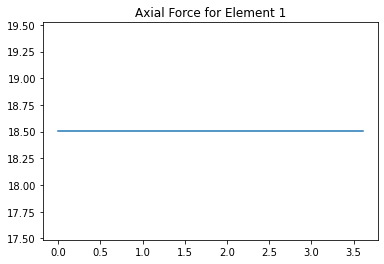

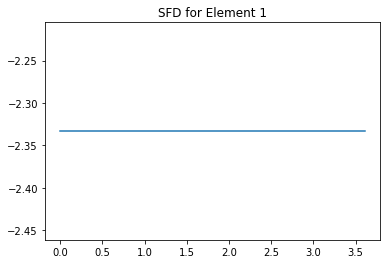

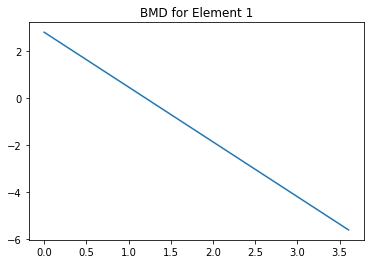

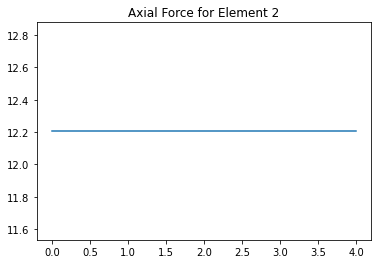

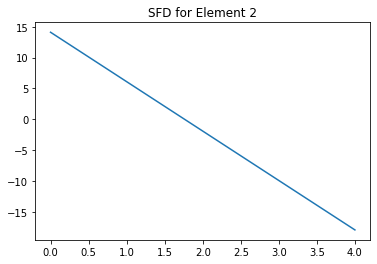

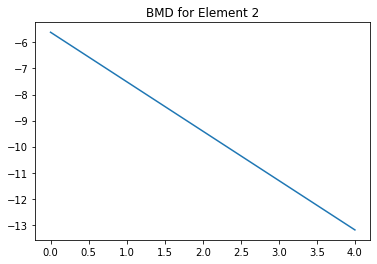

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

#Given Data

E=200000000
A=0.0400
I=0.000001
w=8
n1= [0,3]
n2= [2,0]
n3= [(n2[0]+4),0]

nodes = [(1,2),(2,3)]
angle=[round(360-(math.atan(3/2)*180/math.pi),4),0]

L = [round(math.sqrt( ((n1[1]-n2[1])**2)+((n1[0]-n2[0])**2) ),4),4]
           
dof = 3
non = 3
noe = 2
for i in range(noe):
  C = math.cos(angle[i])
  S = math.sin(angle[i])

k_mat={}
for i in range(noe):
  C = math.cos(angle[i]*math.pi/180)
  S = math.sin(angle[i]*math.pi/180)
  w1=(A*C*C)+(12*I*S*S/(L[i]*L[i]))
  w2=(A*S*S)+(12*I*C*C/(L[i]*L[i]))
  w3=(A-(12*I/(L[i]*L[i])))*C*S
  w4=6*I*S/L[i]
  w5=6*I*C/L[i]
  k_mat[i] = (E/L[i])*np.array([
                                w1,w3,-w4,-w1,-w3,-w4,
                                w3,w2,w5,-w3,-w2,w5,
                                -w4,w5,4*I,w4,-w5,2*I,
                                -w1,-w3,w4,w1,w3,w4,
                                -w3,-w2,-w5,w3,w2,-w5,
                                -w4,w5,2*I,w4,-w5,4*I              
  ]).reshape((2*dof,2*dof))
 
tsm = np.zeros((dof*non,dof*non))
row_adder=[(-1,0,1),(1,2,3),(3,4,5),(5,6,7),(7,8,9),(9,10,11)]
for row in range(noe):
  a,b = nodes[row]
  m,n = k_mat[row].shape

  # 1-2 values
  tsm[a+row_adder[a-1][0],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][0,0:m]
  tsm[a+row_adder[a-1][1],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][1,0:m]
  # rotation 1
  tsm[a+row_adder[a-1][2],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][2,0:m]
  tsm[b+row_adder[b-1][0],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][3,0:m]
  tsm[b+row_adder[b-1][1],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][4,0:m]
  #rotation 2
  tsm[b+row_adder[b-1][2],[a+row_adder[a-1][0],a+row_adder[a-1][1],a+row_adder[a-1][2],b+row_adder[b-1][0],b+row_adder[b-1][1],b+row_adder[b-1][2]]] += k_mat[row][5,0:m]
  
print('Total Stiffness Matrix: \n', np.round(tsm,1))

u=[0,0,0,1,1,1,0,0,0]
F = np.array([0,-w*L[1]/2,-w*L[1]*L[1]/12]).reshape((3,1))
p2 = np.array([0,-w*L[1]/2,-w*L[1]*L[1]/12,0,-w*L[1]/2,w*L[1]*L[1]/12]).reshape((6,1))
count = 0
for i in u:
  if i==1:
    count+=1

reduced_m = []
for i in range(len(u)):
  for j in range(len(u)):
    if u[i]*u[j] == 1:
      reduced_m.append(tsm[i][j])
reduced_m = np.array(reduced_m).reshape((count,count))

disp = np.linalg.solve(reduced_m, F)
print('Displacement: \n', disp)

a=0
b=0
disp_m=[]
for i in u:
  if i == 1:
    disp_m.append(disp[a][0])
    a+=1
  else:
    disp_m.append(u[b])
  b+=1
disp_m = np.array(disp_m).reshape((dof*non,1))

reactions=np.matmul(tsm, disp_m)
print("Reactions:\n",reactions)

u_mat={}
for i in range(len(nodes)):
  a,b = nodes[i]
  u_mat[i] = np.array([disp_m[a+row_adder[a-1][0],0],disp_m[a+row_adder[a-1][1],0],disp_m[a+row_adder[a-1][1]+1,0],disp_m[b+row_adder[b-1][0],0],disp_m[b+row_adder[b-1][1],0],disp_m[b+row_adder[b-1][1]+1,0]]).reshape((6,1))
  
k_dash = {}
for i in range(noe):
  k_dash[i] = np.array([
                        E*A/L[i],0,0,-E*A/L[i],0,0,
                        0,12*E*I/(L[i]**3),6*E*I/(L[i]**2),0,-12*E*I/(L[i]**3),6*E*I/(L[i]**2),
                        0,6*E*I/(L[i]**2),4*E*I/L[i],0,-6*E*I/(L[i]**2),2*E*I/L[i],
                        -E*A/L[i],0,0,E*A/L[i],0,0,
                        0,-12*E*I/(L[i]**3),-6*E*I/(L[i]**2),0,12*E*I/(L[i]**3),-6*E*I/(L[i]**2),
                        0,6*E*I/(L[i]**2),2*E*I/L[i],0,-6*E*I/(L[i]**2),4*E*I/L[i]
  ]).reshape((2*dof,2*dof))

r_mat={}
for i in range(noe):
  C = math.cos(angle[i]*math.pi/180)
  S = math.sin(angle[i]*math.pi/180)
  r_mat[i] = np.array([
                       C,S,0,0,0,0,
                       -S,C,0,0,0,0,
                       0,0,1,0,0,0,
                       0,0,0,C,S,0,
                       0,0,0,-S,C,0,
                       0,0,0,0,0,1
  ]).reshape((2*dof,2*dof))

f_mat={}
for i in range(noe):
  f_mat[i]=np.matmul(np.matmul(k_dash[i],r_mat[i]),u_mat[i])
  print('Nodal Force Vector '+str(i+1)+': \n',f_mat[i])
adj_f={}
f_mat[1]=np.array(f_mat[1]-p2).reshape((6,1))
print('adjusted nodal force vector 2 : \n', f_mat[1])

for i in range(len(L)):
  plt.figure()
  plt.title('Axial Force for Element '+str(i+1))
  plt.plot([0,L[i]],[-1*f_mat[i][0],-1*f_mat[i][0]])
  plt.figure()
  plt.title('SFD for Element '+str(i+1))
  plt.plot([0,L[i]],[f_mat[i][1],-1*f_mat[i][-2]])
  plt.figure()
  plt.title('BMD for Element '+str(i+1))
  plt.plot([0,L[i]],[-1*f_mat[i][2],f_mat[i][-1]])
  plt.show()
